# Main training and testing notebook

This notebook is intended to run on Google Colab and on't work in local

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ensure folder of execution
import os
BASE_DIR = '/content/drive/MyDrive/AIMove/Personal_project/matterport'
os.chdir(BASE_DIR)

In [ ]:
# Version sensitive imports
%tensorflow_version 1.15.0
import tensorflow as tf
!pip install keras==2.1.0 --user
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.0`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
  Using cached https://files.pythonhosted.org/packages/bf/c2/b0c2ece713e754d1692aa432ad682751cd1ad6abf7500a534558b1fbfbe7/Keras-2.1.0-py2.py3-none-any.whl
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
1.15.2


In [ ]:
# ASSERT A GPU COLAB

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
# INFO ON GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar 31 10:14:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Import libraries and tools from matterport maskrcnn

import sys
import itertools
import math
import logging
import json
import re
import random
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
from PIL import Image, ImageDraw
import skimage
import datetime
import keras
import time
from matplotlib.patches import Rectangle


# Import Mask RCNN
sys.path.append(os.path.join(BASE_DIR, "Mask_RCNN"))
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.model import mold_image

# Directory to save logs and trained model
MODEL_DIR = os.path.join(BASE_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(BASE_DIR, "models/mask_rcnn_coco.h5")

# Import coco utilities
sys.path.append(os.path.join(BASE_DIR, "Mask_RCNN/samples/coco"))
import coco
COCO_DIR = os.path.join(BASE_DIR, "Mask_RCNN/samples/coco")

sys.path.append(os.path.join(BASE_DIR, "coco/PythonAPI"))
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

Using TensorFlow backend.


In [ ]:
 # Ensure the version
! pip uninstall imgaug
! pip install imgaug==0.4.0
import imgaug.augmenters as iaa
import imgaug
print(imgaug.__version__)

In [ ]:
# Importation of TV cards dataset
# This dataset was badly imported and I had to make some adjustments like dividing by 4 the sizes

ANNOTATION_FILE_CARDS_ON_TV = os.path.join(BASE_DIR, "..", "tv_cards_dataset", "TV cards", "labels_cards_on_TV_COCO.json")
DATASET_IMG_DIR_CARDS_ON_TV = os.path.join(BASE_DIR, "..", "tv_cards_dataset", "TV cards", "cards_on_TV_resized_renamed")

class CardsOnTVDataset(utils.Dataset):

  def extract_mask(self, image_id):
    with open(ANNOTATION_FILE_CARDS_ON_TV) as f:
      labels = json.load(f)

    # masks (stored as annotations in COCO format)
    annotations = labels['annotations']
    classes = labels['categories']
    images = labels['images']
    id_coco_file = image_id 
    image = next((image for image in images if image["id"] == id_coco_file))

    # dividing by 4 because the images have been resized after labeling....
    image_height = image['height'] // 4
    image_width = image['width'] // 4

    # list containing all the masks of the image of the given id/index
    image_masks = list()

    image_annotations = list((annotation for annotation in annotations if annotation["image_id"] == id_coco_file))
      
    segmentation_tuples = list()
    class_ids = list()

    # only used for drawing 
    empty_mask = np.zeros((image_height,image_width))
    # actual list of masks
    concatenated_mask = np.zeros((image_height,image_width, len(image_annotations)))

    # for each mask (annotation) belonging to the image we draw it and stack them in masks
    for i, annotation in enumerate(image_annotations):

      # orignal list contains a succession of x and y coordinates
      # we reshape that to obtain a list of x,y tuples
      class_ids.append(annotation['category_id'])
      # dividing by 4 because the images have been resized after labeling....
      segmentation_tuples = np.reshape(np.array(annotation["segmentation"][0])// 4, (int(np.array(annotation["segmentation"][0]).size/2), 2))
      img_to_draw_on = Image.fromarray(empty_mask)
      draw = ImageDraw.Draw(img_to_draw_on)
      draw.polygon([tuple(p) for p in segmentation_tuples], fill=1)
      mask = np.asarray(img_to_draw_on)

      concatenated_mask[:, :, i] = mask

    return concatenated_mask.astype('bool_'), image_width, image_height, np.asarray(class_ids, dtype=np.int32)

  def load_cards_on_TV_dataset(self, is_train):
    # Add classes
    self.add_class("cards_on_TV_dataset", 1, "green_card")
    self.add_class("cards_on_TV_dataset", 2, "gold_card")

    for filename in os.listdir(DATASET_IMG_DIR_CARDS_ON_TV):
      
      image_id = filename[:-4]

      # Test set contains 16 images of green cards, 16 images of yellow cards, and 16 images containing both
      # Among each set, we have 4 images of zoomed out cards not cropped, 4 images of zoomed out cards cropped,
      # 4 images of zoomed in cards not cropped, 4 images of zoomed in cards cropped
      # For images where both the cads are present we have 8 images with uncropped cards, 4 with cropped green cards and 4 with cropped yellow cards

      if is_train and int(image_id) in [ 11,  15, 188, 187, 319, 322,  35,  67,  81,  89, 127, 234, 267, 232,  84, 88,
                                          3,   7, 257, 275, 222, 194, 115, 100, 230, 112, 142, 259, 226, 223, 157,258,
                                        244, 272, 159, 120,   9,   2, 137,  28,  19,  23, 204, 310, 312, 303, 237,190, ]:
        continue

      if not is_train and int(image_id) not in [ 11,  15, 188, 187, 319, 322,  35,  67,  81,  89, 127, 234, 267, 232,  84,  88,
                                                  3,   7, 257, 275, 222, 194, 115, 100, 230, 112, 142, 259, 226, 223, 157, 258,
                                                244, 272, 159, 120,   9,   2, 137,  28,  19,  23, 204, 310, 312, 303, 237, 190, ]:
        continue
        
      img_path = os.path.join(DATASET_IMG_DIR_CARDS_ON_TV, filename)


      self.add_image('cards_on_TV_dataset', image_id=image_id, path=img_path, annotation=ANNOTATION_FILE_CARDS_ON_TV)



  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']


  def load_mask(self, image_id):
    info = self.image_info[image_id]

    mask , w, h, class_ids= self.extract_mask(int(info['id']))
        
    return mask, class_ids

  def load_image(self, image_id):
    image = skimage.io.imread(self.image_info[image_id]['path'])

    return image

TV_train_set = CardsOnTVDataset()
TV_train_set.load_cards_on_TV_dataset(is_train=True)
TV_train_set.prepare()
print('Train: %d' % len(TV_train_set.image_ids))

TV_test_set = CardsOnTVDataset()
TV_test_set.load_cards_on_TV_dataset(is_train=False)
TV_test_set.prepare()
print('Test: %d' % len(TV_test_set.image_ids))

Train: 274
Test: 48


In [ ]:
# This function help check that the masks are aligned with the images
def visual_check_dataset(dataset):
  image_id = 1
  image = dataset.load_image(image_id)
  print(image.shape)
  mask, class_ids = dataset.load_mask(image_id)
  print(mask.shape) 

  for j in range(mask.shape[2]):
    plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)


  for i in (count+1 for count in range(9)):



    plt.subplot(330 + 1 + i-1)

    image = dataset.load_image(i)
    plt.imshow(image)

    mask, _ = dataset.load_mask(i)
    for j in range(mask.shape[2]):
      plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)

  plt.show()

In [ ]:
# visual_check_dataset(TV_train_set)
# visual_check_dataset(TV_test_set)

In [ ]:
# Loading of cards in box dataset
ANNOTATION_FILE_CARDS_ON_BOX = os.path.join(BASE_DIR, "..", "tv_cards_dataset", "TV cards", "labels_cards_in_box_COCO.json")
DATASET_IMG_DIR_CARDS_ON_BOX = os.path.join(BASE_DIR, "..", "tv_cards_dataset", "TV cards", "cards_in_box_resized_renamed")

import json
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
class CardsOnBoxDataset(utils.Dataset):

  def extract_mask(self, image_id):
    with open(ANNOTATION_FILE_CARDS_ON_BOX) as f:
      labels = json.load(f)
    # masks (stored as annotations in COCO format)
    annotations = labels['annotations']
    classes = labels['categories']
    images = labels['images']
    id_coco_file = image_id
    image = next((image for image in images if image["id"] == id_coco_file))

    image_height = image['height']
    image_width = image['width']

    # list containing all the masks of the image of the given id/index
    image_masks = list()

    image_annotations = list((annotation for annotation in annotations if annotation["image_id"] == id_coco_file))
      
    segmentation_tuples = list()
    class_ids = list()

    # only used for drawing 
    empty_mask = np.zeros((image_height,image_width))
    # actual list of masks
    concatenated_mask = np.zeros((image_height,image_width, len(image_annotations)))

    # for each mask (annotation) belonging to the image we draw it and stack them in masks
    for i, annotation in enumerate(image_annotations):

      # orignal list contains a succession of x and y coordinates
      # we reshape that to obtain a list of x,y tuples
      class_ids.append(annotation['category_id'])
      segmentation_tuples = np.reshape(np.array(annotation["segmentation"][0]), (int(np.array(annotation["segmentation"][0]).size/2), 2))
      img_to_draw_on = Image.fromarray(empty_mask)
      draw = ImageDraw.Draw(img_to_draw_on)
      draw.polygon([tuple(p) for p in segmentation_tuples], fill=1)
      mask = np.asarray(img_to_draw_on)

      concatenated_mask[:, :, i] = mask

    return concatenated_mask.astype('bool_'), image_width, image_height, np.asarray(class_ids, dtype=np.int32)

  def load_cards_on_box_dataset(self, is_train):
    # Add classes
    self.add_class("cards_on_box_dataset", 1, "green_card")
    self.add_class("cards_on_box_dataset", 2, "gold_card")

    for filename in os.listdir(DATASET_IMG_DIR_CARDS_ON_BOX):
      
      image_id = filename[:-4]

      if is_train and int(image_id) in [ 2, 33, 44, 46, 67,
                                         1,  5, 10, 78, 17,
                                         9, 14, 26, 68, 75 ]:
        continue

      if not is_train and int(image_id) not in [ 2, 33, 44, 46, 67,
                                                 1,  5, 10, 78, 17,
                                                 9, 14, 26, 68, 75 ]:
        continue
        
      img_path = os.path.join(DATASET_IMG_DIR_CARDS_ON_BOX, filename)


      self.add_image('cards_on_box_dataset', image_id=image_id, path=img_path, annotation=ANNOTATION_FILE_CARDS_ON_BOX)



  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']


  def load_mask(self, image_id):
    info = self.image_info[image_id]

    mask , w, h, class_ids= self.extract_mask(int(info['id']))
        
    return mask, class_ids

  def load_image(self, image_id):
    image = skimage.io.imread(self.image_info[image_id]['path'])

    return image

box_train_set = CardsOnBoxDataset()
box_train_set.load_cards_on_box_dataset(is_train=True)
box_train_set.prepare()
print('Train: %d' % len(box_train_set.image_ids))

box_test_set = CardsOnBoxDataset()
box_test_set.load_cards_on_box_dataset(is_train=False)
box_test_set.prepare()
print('Test: %d' % len(box_test_set.image_ids))

Train: 70
Test: 15


In [ ]:
# visual_check_dataset(box_train_set)
# visual_check_dataset(box_test_set)

In [ ]:
# Loading of mixed dataset

ANNOTATION_FILE_MIXED_CARDS = os.path.join(BASE_DIR, "..", "tv_cards_dataset", "TV cards", "labels_mixed_cards_COCO.json")
DATASET_IMG_DIR_MIXED_CARDS = os.path.join(BASE_DIR, "..", "tv_cards_dataset", "TV cards", "mixed_cards_resized_renamed")

class MixedCardsDataset(utils.Dataset):

  def extract_mask(self, image_id):
    with open(ANNOTATION_FILE_MIXED_CARDS) as f:
      labels = json.load(f)
    # masks (stored as annotations in COCO format)
    annotations = labels['annotations']
    classes = labels['categories']
    images = labels['images']
    id_coco_file = image_id
    image = next((image for image in images if image["id"] == id_coco_file))

    image_height = image['height'] 
    image_width = image['width']

    # list containing all the masks of the image of the given id/index
    image_masks = list()

    # image = next((image for image in images if image["id"] == image_id))
    image_annotations = list((annotation for annotation in annotations if annotation["image_id"] == id_coco_file))
      
    segmentation_tuples = list()
    class_ids = list()

    # only used for drawing 
    empty_mask = np.zeros((image_height,image_width))
    # actual list of masks
    concatenated_mask = np.zeros((image_height,image_width, len(image_annotations)))

    # for each mask (annotation) belonging to the image we draw it and stack them in masks
    for i, annotation in enumerate(image_annotations):

      # mask_class = next((mask_class['name'] for mask_class in classes if mask_class["id"] == image_annotations[0]['category_id']))

      # orignal list contains a succession of x and y coordinates
      # we reshape that to obtain a list of x,y tuples
      class_ids.append(annotation['category_id'])
      segmentation_tuples = np.reshape(np.array(annotation["segmentation"][0]), (int(np.array(annotation["segmentation"][0]).size/2), 2))
      img_to_draw_on = Image.fromarray(empty_mask)
      draw = ImageDraw.Draw(img_to_draw_on)
      draw.polygon([tuple(p) for p in segmentation_tuples], fill=1)
      mask = np.asarray(img_to_draw_on)

      concatenated_mask[:, :, i] = mask

    return concatenated_mask.astype('bool_'), image_width, image_height, np.asarray(class_ids, dtype=np.int32)

  def load_mixed_cards_dataset(self, is_train):
    # Add classes
    self.add_class("cards_on_box_dataset", 1, "green_card")
    self.add_class("cards_on_box_dataset", 2, "gold_card")

    for filename in os.listdir(DATASET_IMG_DIR_MIXED_CARDS):
      
      image_id = filename[:-4]

      if is_train and int(image_id) in [ 
                                          9,  16,  23,  53,  79,
                                        104,  91,  78,  98,  27, 
                                          2,  44,  24,  76,  71,
                                        115, 107, 111,  94, 146, 
                                        106, 147, 148, 132, 161,
                                        122, 138, 137, 154, 168, ]:
        continue

      if not is_train and int(image_id) not in [ 
                                          9,  16,  23,  53,  79,
                                        104,  91,  78,  98,  27, 
                                          2,  44,  24,  76,  71,
                                        115, 107, 111,  94, 146, 
                                        106, 147, 148, 132, 161,
                                        122, 138, 137, 154, 168, ]:
        continue
        
      img_path = os.path.join(DATASET_IMG_DIR_MIXED_CARDS, filename)


      self.add_image('cards_on_box_dataset', image_id=image_id, path=img_path, annotation=ANNOTATION_FILE_MIXED_CARDS)



  def image_reference(self, image_id):
    info = self.image_info[image_id]
    return info['path']


  def load_mask(self, image_id):
    info = self.image_info[image_id]

    mask , w, h, class_ids= self.extract_mask(int(info['id']))
        
    return mask, class_ids

  def load_image(self, image_id):
    image = skimage.io.imread(self.image_info[image_id]['path'])

    return image

mixed_train_set = MixedCardsDataset()
mixed_train_set.load_mixed_cards_dataset(is_train=True)
mixed_train_set.prepare()
print('Train: %d' % len(mixed_train_set.image_ids))

mixed_test_set = MixedCardsDataset()
mixed_test_set.load_mixed_cards_dataset(is_train=False)
mixed_test_set.prepare()
print('Test: %d' % len(mixed_test_set.image_ids))

Train: 140
Test: 30


In [ ]:
# visual_check_dataset(mixed_train_set)
# visual_check_dataset(mixed_test_set)

In [ ]:
# In order to train or infer, the model need a configuration containing various parameters

IMG_RESIZE_DIM = 512
DATABASE_SIZE = len(mixed_train_set.image_ids)

class TrainConfig(Config):
    # Give the configuration a recognizable name
    NAME = "train_config"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = IMG_RESIZE_DIM
    IMAGE_MAX_DIM = IMG_RESIZE_DIM

    # Size of test set. There is 322 images in total.
    VALIDATION_STEPS = 322 - DATABASE_SIZE

    # Anchor sizes in pixels
    RPN_ANCHOR_SCALES = (IMG_RESIZE_DIM/16, IMG_RESIZE_DIM/8, IMG_RESIZE_DIM/4, IMG_RESIZE_DIM/2)

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is GPUs * images/GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # DATABASE_SIZE * data augmentation
    STEPS_PER_EPOCH = DATABASE_SIZE*8

    # F2 normalization
    WEIGHT_DECAY = 0.01

    LEARNING_RATE = 0.0025
    
training_config = TrainConfig()
training_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0025
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

In [ ]:
class InferenceConfig(Config):
  NAME = "inference_config"
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  NUM_CLASSES = 1 + 2
  IMAGE_MIN_DIM = IMG_RESIZE_DIM
  IMAGE_MAX_DIM = IMG_RESIZE_DIM

inference_config = InferenceConfig()

Uninstalling imgaug-0.4.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.4.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.4.0
  Using cached https://files.pythonhosted.org/packages/66/b1/af3142c4a85cba6da9f4ebb5ff4e21e2616309552caca5e8acefe9840622/imgaug-0.4.0-py2.py3-none-any.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


In [ ]:
# Augmentation using imgaug. The probability of augmentation has to match the data augmentation
# Exemple: if we mulitply the size of the dataset by 4, then data augmentation should happen 75% (0.75) of the time
augmentation = iaa.Sometimes(0.815,
  iaa.Sequential([
    # image deformations and warps, contrast and saturation jittering I want to happen all the time
    # Sometimes has a bug, probabilities are inverted on this particular instanciation
    iaa.Sometimes(0.5,
      iaa.SomeOf(1, None),
      [
        iaa.OneOf([
          iaa.CropAndPad(percent=(-0.3, 0.3)),
          iaa.Affine(translate_percent=(-0.25, 0.25)),
        ]),
        iaa.Affine(rotate=(-90, 90)),
        iaa.Affine(shear=(-17, 17)),
        iaa.Fliplr(1.0),
        iaa.Flipud(1.0),
        iaa.OneOf([
          iaa.LinearContrast((0.5, 2.0)),
          iaa.Multiply((0.3, 2.5)),         
        ]),
      ]
    ),
    # color saturation changes should happen 75% of the time
    iaa.Sometimes(0.75,
      iaa.OneOf([
        # 2/3 chances to decrease saturation
        iaa.MultiplySaturation((0.1, 0.6)),
        iaa.MultiplySaturation((0.1, 0.6)),
        iaa.MultiplySaturation((1.5, 5))      
      ])
    ),
    # bluring should happen 50% of the time
    iaa.Sometimes(0.5,
      iaa.OneOf([
        iaa.GaussianBlur((0.3, 3.5)),
        iaa.AverageBlur(k=(2, 8)),
        iaa.MedianBlur(k=(3, 13)),
      ]),
    )
  ])
)


0.4.0


In [ ]:
# This code allows to visualize data augmentation

# import random as rand

# for i in range(30):
#   id = rand.randrange(0, 274)

#   image = TV_train_set.load_image(id)

#   image_aug = augmentation.augment_image(image=image)

#   # plt.subplot(1, 5, i+1, figsize=(15,15))
#   plt.imshow(image_aug)
#   plt.show()

In [ ]:
# CUSTOM CALLBACK TO LOG LOSS AND VAL_LOSS BECAUSE TENSORBOARD DOES NOT WORK WITH TF 1.13

class LossStoringCallback(keras.callbacks.Callback):

  def on_train_begin(self, logs=None):
    f_loss = open(os.path.join(BASE_DIR, "logs", "loss.txt" ), "w")
    f_loss.write("[ ")
    f_loss.close()
    f_val_loss = open(os.path.join(BASE_DIR, "logs", "val_loss.txt" ), "w")
    f_val_loss.write("[ ")
    f_val_loss.close()

  def on_epoch_end(self, epoch, logs=None):
    f_loss = open(os.path.join(BASE_DIR, "logs", "loss.txt" ), "a")
    f_loss.write(f'{round(logs["loss"], 3)}, ')
    f_loss.close()
    f_val_loss = open(os.path.join(BASE_DIR, "logs", "val_loss.txt" ), "a")
    f_val_loss.write(f'{round(logs["val_loss"], 3)}, ')
    f_val_loss.close()

  def on_train_end(self, logs=None):
    f_loss = open(os.path.join(BASE_DIR, "logs", "loss.txt" ), "a")
    f_loss.write("]")
    f_loss.close()
    f_val_loss = open(os.path.join(BASE_DIR, "logs", "val_loss.txt" ), "a")
    f_val_loss.write("]")
    f_val_loss.close()

loss_storing_callback = LossStoringCallback()

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss', min_delta=0, patience=7, verbose=0,
  mode='auto', baseline=None, restore_best_weights=True
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
  factor=0.5, patience=3, min_lr=0
)

In [ ]:
# This learning rate scheduler allows starting with a high learning rate by increasing it after the first epochs
# If we satrt from the begining with a high learning rate, the loss funxtions might be unstable and not work
def scheduler(epoch, lr):
  if epoch == 1:
    return lr*2
  else:
    return lr

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# Train
train_model = modellib.MaskRCNN(mode='training', model_dir=os.path.join(BASE_DIR, 'models', 'transfer_learning'), config=training_config)
train_model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
train_model.train(mixed_train_set, mixed_test_set, learning_rate=training_config.LEARNING_RATE, epochs=1000, layers="heads", augmentation=augmentation, custom_callbacks=[lr_scheduler_callback, early_stopping_callback, reduce_lr_callback, loss_storing_callback])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead

Starting at epoch 0. LR=0.0025

Checkpoint Path: /content/drive/MyDrive/AIMove/Personal_project/matterport/models/transfer_learning/train_config20210331T1014/mask_rcnn_train_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2   

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.7/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1000
1120/1120 [==============================] - 410s 366ms/step - loss: 0.9976 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4057 - mrcnn_class_loss: 0.2027 - mrcnn_bbox_loss: 0.2179 - mrcnn_mask_loss: 0.1541 - val_loss: 1.8190 - val_rpn_class_loss: 0.0155 - val_rpn_bbox_loss: 0.4476 - val_mrcnn_class_loss: 0.1070 - val_mrcnn_bbox_loss: 0.0906 - val_mrcnn_mask_loss: 0.1102

Epoch 2/1000
1120/1120 [==============================] - 365s 326ms/step - loss: 0.9757 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.5491 - mrcnn_class_loss: 0.1447 - mrcnn_bbox_loss: 0.1348 - mrcnn_mask_loss: 0.1270 - val_loss: 0.7266 - val_rpn_class_loss: 0.0157 - val_rpn_bbox_loss: 0.5015 - val_mrcnn_class_loss: 0.1481 - val_mrcnn_bbox_loss: 0.0989 - val_mrcnn_mask_loss: 0.1232
Epoch 3/1000
1120/1120 [==============================] - 384s 342ms/step - loss: 0.9681 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.6247 - mrcnn_class_loss: 0.0966 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.1131 - val_loss: 0.

Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-2:
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/usr/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
Keyboar

KeyboardInterrupt: ignored

  File "/usr/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py", line 650, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/content/drive/MyDrive/AIMove/Personal_project/matterport/Mask_RCNN/mrcnn/model.py", line 1711, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/content/drive/MyDrive/AIMove/Personal_project/matterport/Mask_RCNN/mrcnn/model.py", line 1251, in load_image_gt
    image = det.augment_image(image)
  File "/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/meta.py", line 771, in augment_image
    return self.augment_images([image], hooks=hooks)[0]
  File "/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/meta.py", line 825, in augment_images
    hooks=hooks
  File "/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/meta.py", line 645, in augment_batch_
    hooks=hooks)
  File "/usr/local/lib/python3.7/di

In [ ]:
# Model in inference mode
inference_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=os.path.join(BASE_DIR, 'models', 'transfer_learning'))

inference_model.load_weights(os.path.join(BASE_DIR, 'models', "BOX_DATAAUG_8.h5"), by_name=True)

In [ ]:
# You will find here various visualizations of the inference
image = test_set.load_image(0)
scaled_image = mold_image(image, inference_config)
sample = np.expand_dims(scaled_image, 0)
r = inference_model.detect(sample, verbose=0)[0]

masked_image = visualize.display_instances(image, r['rois'], r['masks'],
                                            r['class_ids'], test_set.class_names,
                                            r['scores'])

masked_image.shape

In [ ]:
# Note: there are glitches in the boxes, making some boxes appear superposed when there is only one box
def custom_plot_actual_vs_predicted(dataset, model, cfg, image_id):

  image = dataset.load_image(image_id)
  mask, _ = dataset.load_mask(image_id)

  scaled_image = mold_image(image, cfg)
  sample = np.expand_dims(scaled_image, 0)
  yhat = model.detect(sample, verbose=0)[0]

  plt.imshow(image)
  plt.title('Actual')

  for j in range(mask.shape[2]):
    plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)

  plt.imshow(image)
  plt.title(f'Predicted {image_id}')
  ax = plt.gca()
  for box in yhat['rois']:
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)
    
  plt.show()

In [ ]:
# custom_plot_actual_vs_predicted(test_set, model, inference_config, 11)
for i in range(45):
  custom_plot_actual_vs_predicted(cards_on_box_dataset, inference_model, inference_config, i)

In [ ]:
# Bit of useful code that recover the name of an image, gt and predictions to check if visualizations are correct
image_id = 31
dataset = test_set
config = inference_config
model = inference_model

image = dataset.load_image(image_id)
image_path = dataset.image_reference(image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
results = model.detect([image], verbose=0)
r = results[0]
print(r["masks"].shape)
print(image_path)
print(gt_bbox)

In [ ]:
def display_full_size_predictions(model, dataset, size_dataset, config):
  for image_id in range(size_dataset):
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
      modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]

    # Run object detection
    results = model.detect([image], verbose=0)

    # Display results
    _, ax = plt.subplots(1, 1, figsize=(16, 16))
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=ax,
                                title=f"Predictions {image_id}")

In [ ]:
display_full_size_predictions(inference_model, cards_on_box_dataset, 40, inference_config)

In [ ]:
# Functions that compute mAP from matterport MaskRCNN. Copied to have a close look and add some prints and comments.

def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
    
    # If either set of masks is empty return empty result
    if masks1.shape[-1] == 0 or masks2.shape[-1] == 0:
        return np.zeros((masks1.shape[-1], masks2.shape[-1]))
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return overlaps

def trim_zeros(x):
    """It's common to have tensors larger than the available data and
    pad with zeros. This function removes rows that are all zeros.

    x: [rows, columns].
    """
    assert len(x.shape) == 2
    return x[~np.all(x == 0, axis=1)]

def compute_matches(gt_boxes, gt_class_ids, gt_masks,
                    pred_boxes, pred_class_ids, pred_scores, pred_masks,
                    iou_threshold=0.5, score_threshold=0.0):
    """Finds matches between prediction and ground truth instances.

    Returns:
        gt_match: 1-D array. For each GT box it has the index of the matched
                  predicted box.
        pred_match: 1-D array. For each predicted box, it has the index of
                    the matched ground truth box.
        overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """

    # IMPORTANT
    # The IOU is calculated on masks and not bounding boxes.

    # This whole bit is trimming zero padding and asserting there is the right number of masks and boxes 
    # Useless most of the time in our case
    gt_boxes = trim_zeros(gt_boxes)
    gt_masks = gt_masks[..., :gt_boxes.shape[0]]
    pred_boxes = trim_zeros(pred_boxes)
    pred_scores = pred_scores[:pred_boxes.shape[0]]
    
    # Sort predictions by score from high to low

    # Makes an array in which are the position of each indices after sorting
    indices = np.argsort(pred_scores)[::-1]
    # Sort the arrays
    pred_boxes = pred_boxes[indices]
    pred_class_ids = pred_class_ids[indices]
    pred_scores = pred_scores[indices]
    pred_masks = pred_masks[..., indices]

    # Compute IoU overlaps for masks
    # Overlaps is a confusion matrix with the two mask sets
    overlaps = compute_overlaps_masks(pred_masks, gt_masks)
    
    match_count = 0
    # Put one -1 on the array by prediction
    pred_match = -1 * np.ones([pred_boxes.shape[0]])
    gt_match = -1 * np.ones([gt_boxes.shape[0]])

    # Loop through predicted boxes
    for i in range(len(pred_boxes)):
        # Find best matching ground truth box
        # 1. Sort mask matches by score
        sorted_ixs = np.argsort(overlaps[i])[::-1]
        # 2. Remove scores so low we don't even look at them
        low_score_idx = np.where(overlaps[i, sorted_ixs] < score_threshold)[0]
        if low_score_idx.size > 0:
            sorted_ixs = sorted_ixs[:low_score_idx[0]]
        # 3. Find the match
        for j in sorted_ixs:
            # If current iterating ground truth box is already matched, go to next one
            if gt_match[j] > -1:
                continue
            # If we reach IoU smaller than the threshold, end the loop
            iou = overlaps[i, j]
            if iou < iou_threshold:
                break
            # If classes match
            if pred_class_ids[i] == gt_class_ids[j]:
                match_count += 1
                gt_match[j] = i
                pred_match[i] = j
                break

    return gt_match, pred_match, overlaps


def custom_compute_ap(gt_boxes, gt_class_ids, gt_masks,
               pred_boxes, pred_class_ids, pred_scores, pred_masks,
               iou_threshold=0.5):
    """Compute Average Precision at a set IoU threshold (default 0.5).

    Returns:
    mAP: Mean Average Precision
    precisions: List of precisions at different class score thresholds.
    recalls: List of recall values at different class score thresholds.
    overlaps: [pred_boxes, gt_boxes] IoU overlaps.
    """
    # Get matches and overlaps
    gt_match, pred_match, overlaps = compute_matches(
        gt_boxes, gt_class_ids, gt_masks,
        pred_boxes, pred_class_ids, pred_scores, pred_masks,
        iou_threshold)

    # Compute precision and recall at each prediction box step
    precisions = np.cumsum(pred_match > -1) / (np.arange(len(pred_match)) + 1)
    recalls = np.cumsum(pred_match > -1).astype(np.float32) / len(gt_match)

    # Pad with start and end values to simplify the math
    precisions = np.concatenate([[0], precisions, [0]])
    recalls = np.concatenate([[0], recalls, [1]])

    # Ensure precision values decrease but don't increase. This way, the
    # precision value at each recall threshold is the maximum it can be
    # for all following recall thresholds, as specified by the VOC paper.
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = np.maximum(precisions[i], precisions[i + 1])

    # Compute mean AP over recall range
    indices = np.where(recalls[:-1] != recalls[1:])[0] + 1
    mAP = np.sum((recalls[indices] - recalls[indices - 1]) *
                 precisions[indices])

    return mAP, precisions, recalls, overlaps

In [ ]:
def compute_mAP(model, dataset, nb_images_to_test_on, inference_config, IoU_threshold = 0.5 ):
  # Compute VOC-Style mAP @ IoU=0.5
  APs = []

  # modellib.load_image
  # image: np array of the image
  # image_meta:
  # gt_class_id: class_ids contained in image
  # gt_box: coordinates of boxes in pixels
  # gt_mask: one hot map of masks, with one channel for each class

  for image_id in range(nb_images_to_test_on):
      # Load image and ground truth data
      image, image_meta, gt_class_id, gt_bbox, gt_mask =\
          modellib.load_image_gt(dataset, inference_config,
                                image_id, use_mini_mask=False)
      
      # Type of normalization by substracting the mean pixel
      molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
      # Run object detection
      results = model.detect([image], verbose=0)
      r = results[0]
      # Compute AP
      AP, precisions, recalls, overlaps =\
          custom_compute_ap(gt_bbox, gt_class_id, gt_mask,
                          r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold = IoU_threshold)
      APs.append(AP)
      
  return np.mean(APs)

In [ ]:
# Compute primary challenge metric of COCO: mAP@.5:0.05:0.95
mAPs = []

# range() only works with ints...
for IoU in range(50, 100, 5):
  IoU /= 100
  mAPs.append(compute_mAP(inference_model, TV_test_set, 48, inference_config, IoU_threshold = IoU ))
  print(f'IoU {IoU} OK')

print(f'COCO primary challenge metric: {round(np.mean(mAPs), 4)}')
print(f'PASCAL VOC 2012 metric: {round(mAPs[0], 4)}')
print(f'COCO strict metric: {round(mAPs[5], 4)}')
print(f'  0.50    0.55    0.60    0.65    0.70    0.75    0.80    0.85    0.90    0.95')
print(f'[ {round(mAPs[0], 4)}, {round(mAPs[1], 4)}, {round(mAPs[2], 4)}, {round(mAPs[3], 4)}, {round(mAPs[4], 4)}, {round(mAPs[5], 4)}, {round(mAPs[6], 4)}, {round(mAPs[7], 4)}, {round(mAPs[8], 4)}, {round(mAPs[9], 4)} ]')


IoU 0.5 OK
IoU 0.55 OK
IoU 0.6 OK
IoU 0.65 OK
IoU 0.7 OK
IoU 0.75 OK
IoU 0.8 OK
IoU 0.85 OK
IoU 0.9 OK
IoU 0.95 OK
COCO primary challenge metric: 0.3691
PASCAL VOC 2012 metric: 0.6196
COCO strict metric: 0.3866
  0.50    0.55    0.60    0.65    0.70    0.75    0.80    0.85    0.90    0.95
[ 0.6196, 0.5988, 0.5486, 0.5141, 0.4585, 0.3866, 0.3325, 0.1901, 0.0417, 0.0 ]


In [ ]:
# Compute primary challenge metric of COCO: mAP@.5:0.05:0.95
mAPs = []

# range() only works with ints...
for IoU in range(50, 100, 5):
  IoU /= 100
  mAPs.append(compute_mAP(inference_model, box_test_set, 15, inference_config, IoU_threshold = IoU ))
  print(f'IoU {IoU} OK')

print(f'COCO primary challenge metric: {round(np.mean(mAPs), 4)}')
print(f'PASCAL VOC 2012 metric: {round(mAPs[0], 4)}')
print(f'COCO strict metric: {round(mAPs[5], 4)}')
print(f'  0.50    0.55    0.60    0.65    0.70    0.75    0.80    0.85    0.90    0.95')
print(f'[ {round(mAPs[0], 4)}, {round(mAPs[1], 4)}, {round(mAPs[2], 4)}, {round(mAPs[3], 4)}, {round(mAPs[4], 4)}, {round(mAPs[5], 4)}, {round(mAPs[6], 4)}, {round(mAPs[7], 4)}, {round(mAPs[8], 4)}, {round(mAPs[9], 4)} ]')

IoU 0.5 OK
IoU 0.55 OK
IoU 0.6 OK
IoU 0.65 OK
IoU 0.7 OK
IoU 0.75 OK
IoU 0.8 OK
IoU 0.85 OK
IoU 0.9 OK
IoU 0.95 OK
COCO primary challenge metric: 0.8189
PASCAL VOC 2012 metric: 0.9889
COCO strict metric: 0.9667
  0.50    0.55    0.60    0.65    0.70    0.75    0.80    0.85    0.90    0.95
[ 0.9889, 0.9889, 0.9889, 0.9889, 0.9667, 0.9667, 0.9, 0.9, 0.4833, 0.0167 ]


In [ ]:
# Time the detection
nb_images = 100
images = []
for image_id in range(nb_images):
  image_raw = TV_train_set.load_image(image_id)
  image = mold_image(image_raw, inference_config)
  images.append(image)
  
print("Image loading done")

start_time = time.time()
for i in range(nb_images):
  _ = inference_model.detect([images[i]], verbose=0)
end_time = time.time()

print(f'Time elapsed: {round(end_time - start_time, 2)} second(s)')
print(f'Mean detection time: {round((end_time - start_time)/nb_images, 2)} second')


Image loading done
Time elapsed: 22.96 second(s)
Mean detection time: 0.23 second


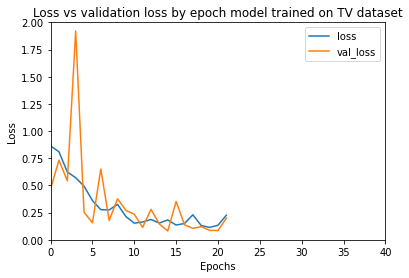

In [ ]:
# Useful to plot loss and val loss
def plot_loss_vs_val_loss(loss, val_loss, name):

  plt.plot(loss, label='loss', color='tab:blue')
  plt.plot(val_loss, label='val_loss', color='tab:orange')

  plt.xlim(0, 40)
  plt.ylim(0, 2)

  plt.legend()
  plt.xlabel('Epochs') 
  plt.ylabel('Loss') 
  plt.title(f'Loss vs validation loss by epoch {name}') 
  plt.show()

loss = [ 0.863, 0.81, 0.624, 0.571, 0.493, 0.361, 0.277, 0.275, 0.326, 0.214, 0.153, 0.164, 0.187, 0.154, 0.183, 0.136, 0.15, 0.23, 0.131, 0.114, 0.134, 0.226, ]
val_loss = [ 0.468, 0.732, 0.542, 1.92, 0.254, 0.156, 0.651, 0.178, 0.377, 0.271, 0.235, 0.114, 0.28, 0.145, 0.081, 0.353, 0.138, 0.105, 0.121, 0.087, 0.085, 0.199, ]

plot_loss_vs_val_loss(loss, val_loss, 'model trained on TV dataset')

In [ ]:
# Useful to compare the inference times
import matplotlib.pyplot as plt

x = ['i7-10750H', 'GTX 850M', 'RTX 2060 6G', 'Tesla T4', 'Paper']
y = [ 1.34, 1.44, 0.6, 0.23, 0.2 ]

plt.bar(x, y)

plt.xlabel('hardware') 
plt.ylabel('Time of inference in seconds') 
plt.title('Time of inference by hardware') 